In [49]:
import pandas as pd
from thefuzz import fuzz
from thefuzz import process
from unidecode import unidecode
import nltk
import hazm
import string
import re
import numpy as np

In [50]:
df_all=pd.read_csv('D:\quera\\bootcamp\examples\Laptop_analysis_and_Warehousing_g3\Data Source\\all_data_c.csv')
df_sel=pd.read_csv('D:\quera\\bootcamp\examples\Laptop_analysis_and_Warehousing_g3\Data Source\sales_data\sales_data.csv')

In [51]:
df_all.dropna(inplace=True)

In [52]:
idx=df_sel[['Manufacturer',
       'Model_Name', 'Category', 'Screen_Size', 'Screen', 'CPU', 'RAM',
       'Storage', 'GPU', 'OS', 'OS_Version', 'Weight']].drop_duplicates().index

In [53]:
idx1=df_all[['Id','Manufacturer','Attributes']].drop_duplicates().index

In [54]:
df_sel=df_sel.loc[idx]
df_all=df_all.loc[idx1]

In [55]:
df_sel['text']=df_sel['Manufacturer']+' '+df_sel['Model_Name']+' '+df_sel['Screen_Size']+' '+df_sel['CPU']+' '+df_sel['RAM']+' '+df_sel['Storage']+' '+df_sel['GPU']

In [56]:
df_final=df_sel.copy()

In [57]:
df_all['text']=df_all.Attributes

In [58]:
def remove_ir(text):
    try:
        t=[]
        tokens = text.split(' ')
        for i in range(len(tokens)):
            t.append(''.join(re.findall(r'[0-9َA-Za-z۰-۹]', tokens[i])))
        return "  ".join(t)
    except:print(text)
df_sel['text'] = df_sel['text'].apply(lambda x: remove_ir(x))
df_all['text'] = df_all['text'].apply(lambda x: remove_ir(x))

In [59]:
def convert_to_lower(text):
    return text.lower()
df_sel['text'] = df_sel['text'].apply(lambda x: convert_to_lower(x))
df_all['text'] = df_all['text'].apply(lambda x: convert_to_lower(x))

In [60]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df_sel['text'] = df_sel['text'].apply(lambda x: remove_punctuation(x))
df_all['text'] = df_all['text'].apply(lambda x: remove_punctuation(x))

In [61]:
with open('stopwords.txt',encoding='utf-8') as stopwords_file:
    stopwords=stopwords_file.readlines()
stopwords=[line.replace('\n','') for line in stopwords]
nltk.download('stopwords')
nltk_stopwords=nltk.corpus.stopwords.words('english')
stopwords.extend(nltk_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aghil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
def remove_stopwords(text):
    removed = []
    stop_words = stopwords
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)
df_sel['text'] = df_sel['text'].apply(lambda x: remove_stopwords(x))
df_all['text'] = df_all['text'].apply(lambda x: remove_stopwords(x))

In [63]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z0-9آ-ی۰-۹]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc
df_sel['text'] = df_sel['text'].apply(lambda x: remove_extra_white_spaces(x))
df_all['text'] = df_all['text'].apply(lambda x: remove_extra_white_spaces(x))

In [64]:
def stemmering_e(text):
    stemmer = nltk.SnowballStemmer('english')
    tokens = nltk.word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = stemmer.stem(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)
df_sel['text'] = df_sel['text'].apply(lambda x: stemmering_e(x))
df_all['text'] = df_all['text'].apply(lambda x: stemmering_e(x))

In [65]:
def unicode(text):
    return unidecode(text)
df_sel['text'] = df_sel['text'].apply(lambda x: unicode(x))
df_all['text'] = df_all['text'].apply(lambda x: unicode(x))

In [66]:
df_sel.text

0        dell vostro 3568 156 intel core i5 7200u 25ghz...
1        lenovo yoga 72013ikb 133 intel core i5 7200u 2...
2        lenovo ideapad y70015isk 156 intel core i7 670...
3        dell inspiron 5370 133 intel core i7 8550u 18g...
4        acer aspir e5576g 156 intel core i5 7200u 25gh...
                               ...                        
42041    dell xps 15 156 intel core i5 6300hq 23ghz 8gb...
42351    hp 15bs018nq i36006u4gb500gbfhdno 156 intel co...
44770    dell alienwar 17 173 intel core i7 6820hk 27gh...
47963    dell alienwar 15 156 intel core i7 7700hq 28gh...
61944    hp 250 g6 156 intel core i3 6006u 2ghz 4gb 500...
Name: text, Length: 1252, dtype: object

In [67]:
pr=[]
for index,row in df_sel.iterrows():
    for index_base,row_base in df_all.iterrows():
        #print(fuzz.token_sort_ratio(row_base['text'], row['text']))
        if fuzz.token_sort_ratio(row_base['text'], row['text'])<20:
            pr.append(row_base['Id'])

In [68]:
len(set(pr))

898

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN,KMeans,MeanShift
import numpy as np

In [70]:
tfidf=TfidfVectorizer()

In [71]:
tfidf.fit(df_sel.text)

TfidfVectorizer()

In [72]:
xtrain=tfidf.transform(df_sel.text)

In [73]:
xtrain

<1252x967 sparse matrix of type '<class 'numpy.float64'>'
	with 19459 stored elements in Compressed Sparse Row format>

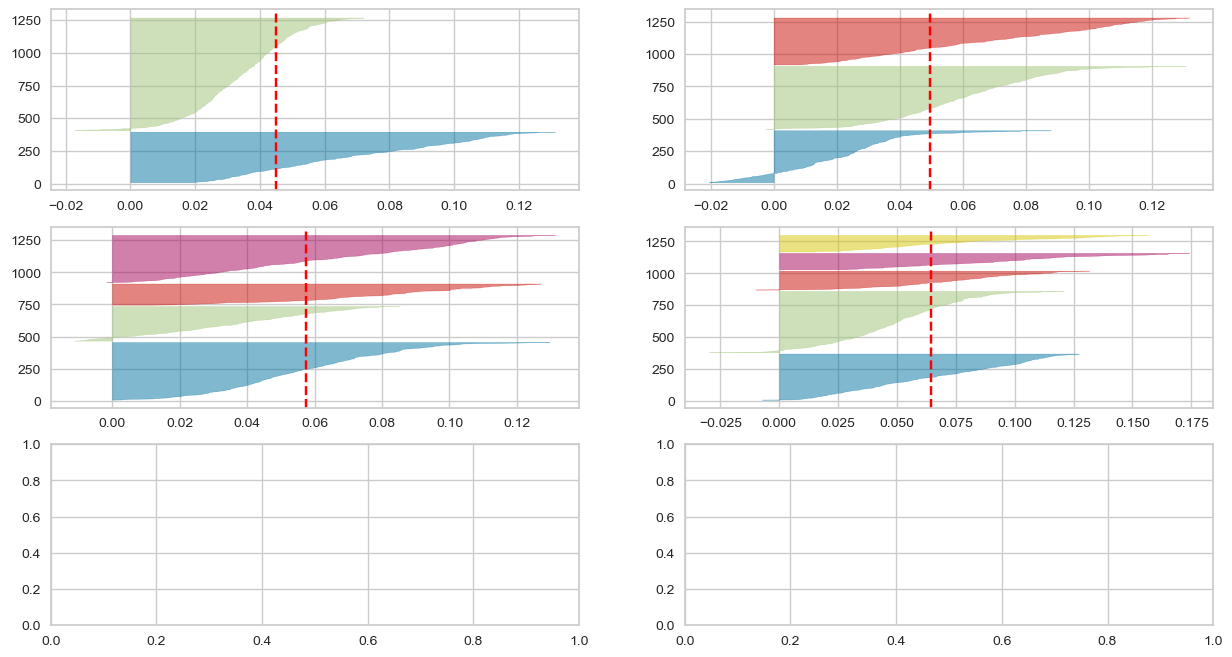

In [74]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

X = xtrain
  
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X) 

In [75]:
from sklearn.decomposition import PCA

In [76]:
p=PCA(n_components=3)

In [77]:
Xp=p.fit_transform(X.toarray())

In [78]:
np.shape(Xp)

(1252, 3)

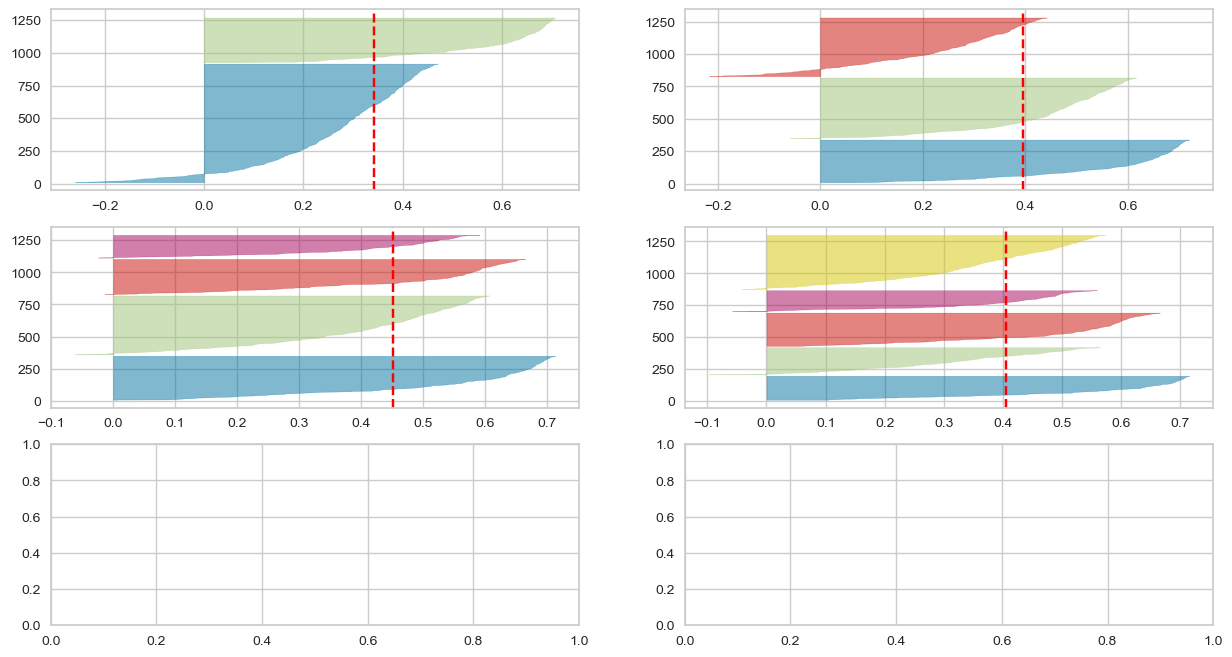

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2,3,4,5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xp) 

In [80]:
wcss ={}
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init='auto')
    kmeans.fit(Xp) 
    wcss[i]=(kmeans.inertia_)

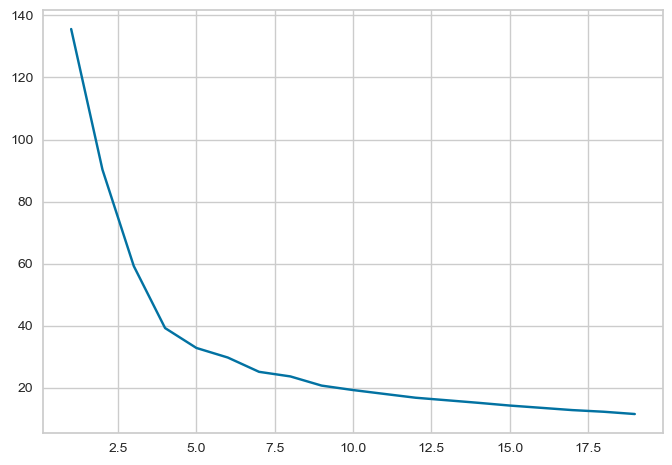

In [81]:
plt.plot (list (wcss.keys ()), list (wcss.values ()))

In [82]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42,n_init='auto')
kmeans.fit(Xp) 

KMeans(n_clusters=4, n_init='auto', random_state=42)

In [83]:
pd.DataFrame(kmeans.labels_).value_counts()

1    459
0    342
2    274
3    177
dtype: int64

In [84]:
model=DBSCAN(eps=0.5)

In [85]:
model.fit(Xp)

DBSCAN()

In [86]:
pd.DataFrame(model.labels_).value_counts()

0    1252
dtype: int64

In [87]:
len(df_sel)

1252

In [88]:
len(df_final)

1252

In [89]:
df_final['lable']=kmeans.labels_

In [90]:
df_sel['lable']=kmeans.labels_

In [91]:
from collections import Counter

In [92]:
for i in range(4):
    print('lable: ',i,'\n')
    print(Counter(" ".join(df_sel[df_sel['lable'] == i]["text"]).split()).most_common(20))

lable:  0 

[('intel', 343), ('core', 340), ('nvidia', 335), ('geforc', 306), ('i7', 279), ('ssd', 276), ('hdd', 230), ('gtx', 230), ('1tb', 227), ('156', 201), ('8gb', 165), ('28ghz', 150), ('7700hq', 143), ('256gb', 142), ('16gb', 134), ('173', 123), ('1050', 91), ('128gb', 76), ('asus', 72), ('dell', 69)]
lable:  1 

[('intel', 889), ('core', 462), ('graphic', 430), ('ssd', 392), ('hd', 353), ('8gb', 334), ('620', 302), ('256gb', 283), ('i5', 265), ('i7', 182), ('25ghz', 180), ('7200u', 149), ('156', 140), ('133', 139), ('hp', 130), ('140', 127), ('lenovo', 122), ('dell', 93), ('520', 84), ('512gb', 81)]
lable:  2 

[('intel', 521), ('core', 259), ('graphic', 249), ('hd', 248), ('4gb', 224), ('156', 149), ('hdd', 136), ('i3', 105), ('520', 94), ('celeron', 78), ('ssd', 74), ('dual', 73), ('500gb', 72), ('lenovo', 65), ('flash', 63), ('storag', 63), ('1tb', 62), ('6006u', 61), ('hp', 54), ('2ghz', 53)]
lable:  3 

[('amd', 213), ('156', 151), ('radeon', 150), ('intel', 131), ('hdd', 

In [112]:
df_sel_all=pd.read_csv('D:\quera\\bootcamp\examples\Laptop_analysis_and_Warehousing_g3\Data Source\sales_data\sales_data.csv')

In [113]:
df_sel_all['text']=df_sel_all['Manufacturer']+' '+df_sel_all['Model_Name']+' '+df_sel_all['Screen_Size']+' '+df_sel_all['CPU']+' '+df_sel_all['RAM']+' '+df_sel_all['Storage']+' '+df_sel_all['GPU']

In [114]:
df_sel_all['lable']=0

In [115]:
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: remove_ir(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: convert_to_lower(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: remove_punctuation(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: remove_stopwords(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: remove_extra_white_spaces(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: stemmering_e(x))
df_sel_all['text'] = df_sel_all['text'].apply(lambda x: unicode(x))

In [117]:
for idx,row in df_sel.iterrows():
    print(row['text'])
    df_sel_all.loc[df_sel_all.text.str.contains(row['text']),'lable']=row['lable']

dell vostro 3568 156 intel core i5 7200u 25ghz 8gb 256gb ssd amd radeon r5 m420
lenovo yoga 72013ikb 133 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
lenovo ideapad y70015isk 156 intel core i7 6700hq 26ghz 8gb 1tb hdd nvidia geforc gtx 960m
dell inspiron 5370 133 intel core i7 8550u 18ghz 8gb 256gb ssd amd radeon 530
acer aspir e5576g 156 intel core i5 7200u 25ghz 4gb 256gb ssd nvidia geforc 940mx
lenovo ideapad y70015acz 156 amd fx 8800p 21ghz 16gb 512gb ssd 1tb hdd amd radeon r9 m385
lenovo ideapad 32015ikb 156 intel core i7 7500u 27ghz 4gb 1tb hdd nvidia geforc 920mx
lenovo thinkpad e570 156 intel core i5 7200u 25ghz 8gb 1tb hdd intel hd graphic 620
dell precis 3510 156 intel core i5 6440hq 26ghz 8gb 500gb hdd amd firepro w5130m
lenovo legion y52015ikbn 156 intel core i7 7700hq 28ghz 4gb 1tb hdd nvidia geforc gtx 1050
hp probook 440 140 intel core i7 8550u 18ghz 8gb 512gb ssd intel uhd graphic 620
fujitsu lifebook a556 156 intel core i5 6200u 23ghz 4gb 256gb ssd inte

lenovo ideapad 32017ikb 173 intel core i5 7200u 25ghz 6gb 1tb hdd nvidia geforc gtx 940m
hp elitebook 1040 140 intel core i7 6600u 26ghz 8gb 256gb ssd intel hd graphic 520
hp elitebook 840 140 intel core i7 6500u 25ghz 8gb 512gb ssd intel hd graphic 520
asus fx502vmdm560t i77700hq8gb1tb 156 intel core i7 7700hq 28ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx1060
hp probook 430 133 intel core i5 8250u 16ghz 4gb 128gb ssd intel uhd graphic 620
asus x505bpbr019t a994204gb1tbradeon 156 amd a9seri 9420 3ghz 4gb 1tb hdd amd radeon r5 m420
lenovo legion y52015ikbn 156 intel core i7 7700hq 28ghz 8gb 256gb ssd nvidia geforc gtx 1050m
razer blade stealth 125 intel core i7 7500u 25ghz 16gb 512gb ssd intel hd graphic 620
asus zenbook flip 133 intel core i7 7500u 27ghz 16gb 512gb ssd intel hd graphic 620
dell inspiron 7560 156 intel core i7 7500u 27ghz 8gb 128gb ssd 1tb hdd nvidia geforc 940mx
acer travelm 116 intel pentium quad core n3710 16ghz 4gb 128gb flash storag intel hd graphic 405
hp eliteboo

asus x751nvty001t n42004gb1tbgeforc 173 intel pentium quad core n4200 11ghz 4gb 1tb hdd nvidia geforc 920mx
lenovo thinkpad t460 140 intel core i7 6600u 26ghz 8gb 256gb ssd intel hd graphic 520
dell inspiron 7577 156 intel core i7 7700hq 28ghz 16gb 128gb ssd 1tb hdd nvidia geforc gtx 1050 ti
asus rog gl553vefy022 156 intel core i7 7700hq 28ghz 8gb 1tb hdd nvidia geforc gtx 1050 ti
toshiba tecra a50d11m 156 intel core i5 7200u 25ghz 8gb 500gb hdd intel hd graphic 620
hp 15bw003nv a9series94204gb256gbfhdw10 156 amd a9seri 9420 3ghz 4gb 256gb ssd amd radeon r5
hp elitebook 820 125 intel core i7 7500u 27ghz 8gb 256gb ssd intel hd graphic 620
lenovo thinkpad e570 156 intel core i3 6006u 20ghz 4gb 128gb ssd intel hd graphic 520
microsoft surfac laptop 135 intel core i5 7200u 25ghz 4gb 128gb ssd intel hd graphic 620
dell latitud 3480 140 intel core i3 6006u 2ghz 4gb 500gb hdd intel hd graphic 520
lenovo ideapad 50015isk 156 intel core i7 6500u 25ghz 16gb 1tb hybrid amd radeon r7 m360
lenovo t

hp zbook 15u 156 intel core i7 7500u 27ghz 8gb 1tb hdd amd firepro w4190m
lenovo thinkpad 13 133 intel core i5 7200u 25ghz 4gb 128gb ssd intel hd graphic 620
asus r558uadm966t i57200u8gb128gbfhdw10 156 intel core i5 7200u 25ghz 8gb 128gb hdd intel hd graphic 620
acer aspir e5576g 156 intel core i7 7500u 27ghz 8gb 256gb ssd nvidia geforc 940mx
lenovo legion y52015ikbn 156 intel core i5 7300hq 25ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx 1060
asus x541napd1003i n42004gb500gbw10 156 intel pentium quad core n4200 11ghz 4gb 500gb hdd intel hd graphic 500
hp noteb pav 156 intel core i7 7500u 27ghz 8gb 1tb hdd nvidia geforc 940mx
lenovo legion y52015ikbn 156 intel core i7 7700hq 28ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx 1060
lenovo lenovo ideapad 116 intel celeron dual core n3350 11ghz 2gb 32gb flash storag intel hd graphic 500
hp 250 g6 156 intel core i7 7500u 27ghz 8gb 256gb ssd intel hd graphic 620
acer aspir r7 133 intel core i5 6200u 23ghz 8gb 256gb ssd intel hd graphic 520
hp probo

acer aspir 156 intel core i7 7700hq 28ghz 8gb 256gb ssd nvidia geforc gtx 1050
toshiba tecra z40c136 140 intel core i7 6600u 26ghz 8gb 256gb ssd intel hd graphic 520
lenovo thinkpad t470p 140 intel core i7 7700hq 28ghz 8gb 512gb ssd nvidia geforc gt 940mx
acer cb5132tc9kk n31604gb32gbchrome 116 intel celeron quad core n3160 16ghz 4gb 32gb flash storag intel hd graphic 400
lenovo thinkpad t460s 140 intel core i7 6600u 26ghz 12gb 256gb ssd intel hd graphic 520
asus zenbook ux430un 140 intel core i7 8550u 18ghz 16gb 512gb ssd nvidia geforc mx150
dell inspiron 5770 173 intel core i5 8250u 16ghz 8gb 128gb ssd 1tb hdd amd radeon 530
lenovo thinkpad l470 140 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
asus q524uqbhi7t15 i77500u12gb2tbgeforc 156 intel core i7 7500u 27ghz 12gb 2tb hdd nvidia geforc 940mx
hp zbook 15 156 intel core i7 7700hq 28ghz 8gb 256gb ssd nvidia quadro m1200
lenovo legion y72015ikb 156 intel core i7 7700hq 28ghz 8gb 1tb hdd nvidia geforc gtx 1060
hp proboo

dell vostro 3568 156 intel core i3 6006u 2ghz 4gb 1tb hdd amd radeon r5 m420
toshiba satellit pro 133 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
msi gs70 stealth 173 intel core i7 6700hq 26ghz 8gb 256gb ssd nvidia geforc gtx 965m
hp probook 470 173 intel core i5 8250u 16ghz 8gb 128gb ssd 1tb hdd nvidia geforc 930mx
hp pavilion x360 133 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
asus rog strix 173 intel core i7 7700hq 28ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx 1060
appl macbook 12 120 intel core 12ghz 8gb 512gb flash storag intel hd graphic 5300
dell inspiron 5379 133 intel core i5 8250u 16ghz 8gb 256gb ssd intel uhd graphic 620
dell inspiron 7773 173 intel core i5 8250u 16ghz 12gb 1tb hdd nvidia geforc 150mx
acer aspir 156 intel core i7 8550u 18ghz 8gb 1tb hdd nvidia geforc mx150
hp elitebook 820 125 intel core i5 6200u 23ghz 4gb 128gb ssd intel hd graphic 520
asus zenbook flip 156 intel core i7 7500u 27ghz 12gb 512gb ssd 2tb hdd nvidia geforc gt

lenovo v33015ikb i78550u8gb256gbfhdw10 156 intel core i7 8550u 18ghz 8gb 256gb ssd intel uhd graphic 620
hp zbook 15u 156 intel core i7 6500u 25ghz 8gb 256gb ssd amd firepro w4190m
lenovo thinkpad t460 140 intel core i5 6200u 23ghz 4gb 508gb hybrid intel hd graphic 520
lenovo thinkpad l570 156 intel core i5 7200u 25ghz 4gb 500gb hdd intel hd graphic 620
dell inspiron 5570 156 intel core i7 8550u 18ghz 8gb 128gb ssd 1tb hdd intel uhd graphic 620
asus k556urdm621t i77500u8gb256gbgeforc 156 intel core i7 7500u 27ghz 8gb 256gb ssd nvidia geforc gtx 930mx
dell inspiron 3576 156 intel core i7 8550u 18ghz 8gb 256gb ssd amd radeon 520
lenovo thinkpad yoga 133 intel core i7 7500u 27ghz 8gb 256gb ssd intel hd graphic 620
dell inspiron 5567 156 intel core i7 7500u 27ghz 8gb 1tb hdd amd radeon r7 m445
msi gt72s domin 173 intel core i7 6820hk 27ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx 980m
dell latitud 5480 140 intel core i5 7440hq 28ghz 8gb 256gb ssd nvidia geforc 930mx
dell inspiron 5567 156 

msi gs60 ghost 156 intel core i7 6700hq 26ghz 16gb 128gb ssd 1tb hdd nvidia geforc gtx 970m
dell precis 3520 156 intel core i7 6820hq 27ghz 16gb 256gb ssd nvidia quadro m620
hp probook 440 140 intel core i5 7200u 25ghz 4gb 256gb ssd intel hd graphic 620
toshiba tecra x40d10z 140 intel core i5 7200u 25ghz 4gb 128gb ssd intel hd graphic 620
lenovo legion y52015ikbn 156 intel core i7 7700hq 28ghz 16gb 512gb ssd nvidia geforc gtx 1050 ti
asus rog gl552vwcn470t 156 intel core i7 6700hq 26ghz 16gb 128gb ssd 1tb hdd nvidia geforc gtx 960m
dell vostro 3568 156 intel core i3 6006u 20ghz 4gb 1tb hdd amd radeon r5 m420x
dell inspiron 7567 156 intel core i7 7700hq 28ghz 8gb 1tb hybrid nvidia geforc gtx 1050
asus fx753vegc155t i77700hq16gb1tb 173 intel core i7 7700hq 28ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx1050 ti
lenovo ideapad 31015isk 156 intel core i3 6006u 2ghz 4gb 1tb hdd intel hd graphic 520
appl macbook pro 154 intel core i7 27ghz 16gb 512gb ssd amd radeon pro 455
asus rog g752vlgc088

lenovo ideapad 51015ikb 156 intel core i7 7500u 27ghz 6gb 256gb ssd nvidia geforc 940mx
acer nitro an51551 156 intel core i5 7300hq 25ghz 8gb 256gb ssd nvidia geforc gtx 1050
hp 17bs092nd i36006u8gb256gbw10 173 intel core i3 6006u 2ghz 8gb 256gb ssd intel hd graphic 520
lenovo ideapad y70015isk 156 intel core i7 6700hq 26ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx 960u039c
lenovo thinkpad x1 140 intel core i7 6500u 25ghz 8gb 512gb ssd intel hd graphic 520
lenovo ideapad 32015ikbn 156 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
lenovo ideapad 120s14iap 140 intel celeron dual core n3350 11ghz 4gb 32gb flash storag intel hd graphic 500
lenovo legion y52015ikbn 156 intel core i7 7700hq 28ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx 1050 ti
dell vostro 5568 156 intel core i5 7200u 25ghz 8gb 1tb hdd intel hd graphic 620
msi gp62m leopard 156 intel core i7 7700hq 28ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx 1050
hp elitebook 1030 133 intel core 6y54 11ghz 8gb 256gb ssd intel

lenovo thinkpad p40 140 intel core i7 6600u 26ghz 8gb 512gb ssd nvidia quadro m500m
lenovo ideapad 31015isk 156 intel core i3 6100u 23ghz 6gb 128gb ssd nvidia geforc 920mx
acer aspir a51551g59qf 156 intel core i5 8250u 16ghz 4gb 1tb hdd nvidia geforc mx150
asus vivobook s15 156 intel core i7 8550u 18ghz 8gb 256gb ssd nvidia geforc 940mx
acer nitro 156 intel core i7 7700hq 28ghz 8gb 128gb ssd 1tb hdd nvidia geforc gtx 1050
hp 15bs011nv i77500u4gb500gbradeon 156 intel core i7 7500u 27ghz 4gb 500gb hdd amd radeon 530
asus x555qgdm242t a109620p4gb1tb 156 amd a10seri a109620p 25ghz 4gb 128gb ssd 1tb hdd amd radeon r5 m430
lenovo thinkpad l460 140 intel core i5 6200u 23ghz 8gb 256gb ssd intel hd graphic 520
hp zbook 15u 156 intel core i5 7200u 25ghz 8gb 500gb hdd amd firepro w4190m
lenovo v31015ikb i57200u4gb1tbno 156 intel core i5 7200u 25ghz 4gb 1tb hdd intel hd graphic 620
lenovo ideapad 32017ikb 173 intel core i5 7200u 25ghz 8gb 1tb hdd intel hd graphic 620
acer swift 140 intel core i3 7

toshiba tecra x40d10g 140 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
lenovo ideapad 32015ikbn 156 intel core i5 7200u 25ghz 8gb 2tb hdd intel hd graphic 620
dell xps 13 133 intel core i7 7500u 27ghz 8gb 256gb ssd intel hd graphic 620
hp 15bs024nv i57200u8gb128gbw10 156 intel core i5 7200u 25ghz 8gb 128gb ssd intel hd graphic 620
dell latitud e5470 140 intel core i3 6100u 23ghz 8gb 128gb ssd intel hd graphic 520
asus rog gl753veds74 173 intel core i7 7700hq 28ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx 1050 ti
lenovo thinkpad x1 140 intel core i7 6600u 26ghz 16gb 256gb ssd intel hd graphic 520
dell alienwar 17 173 intel core i7 7700hq 28ghz 32gb 1tb ssd 1tb hdd nvidia geforc gtx 1070
lenovo thinkpad x1 140 intel core i5 6200u 23ghz 8gb 256gb ssd intel hd graphic 520
hp probook 430 133 intel core i7 7500u 27ghz 8gb 256gb ssd intel hd graphic 620
lenovo ideapad 32015ikbn 156 intel core i5 7200u 25ghz 8gb 256gb ssd nvidia geforc 940mx
microsoft surfac laptop 135 intel co

hp 250 g5 156 intel core i5 7200u 25ghz 4gb 500gb hdd intel hd graphic 620
asus zenbook pro 156 intel core i7 7700hq 28ghz 16gb 512gb ssd nvidia geforc gtx 1050 ti
dell inspiron 3567 156 intel core i3 7100u 24ghz 6gb 1tb hdd intel hd graphic 620
hp elitebook 850 156 intel core i5 6300u 24ghz 8gb 256gb ssd intel hd graphic 520
lenovo v31015isk i36006u4gb1tbfhdw10 156 intel core i3 6006u 2ghz 4gb 1tb hdd intel hd graphic 520
acer aspir 156 intel celeron dual core n3350 2ghz 4gb 1tb hdd intel hd graphic 500
lenovo v31015isk i57200u4gb1tbfhdw10 156 intel core i5 7200u 25ghz 4gb 1tb hdd intel hd graphic 620
msi gt80s 6qe 173 intel core i7 6820hk 27ghz 16gb 128gb ssd 1tb hdd nvidia geforc gtx 980m
asus r417nars01 n33504gb32gbw10 140 intel celeron dual core n3350 11ghz 4gb 32gb flash storag intel hd graphic 500
dell vostro 3568 156 intel core i3 6006u 20ghz 4gb 1tb hdd intel hd graphic 520
hp probook 450 156 intel core i3 6100u 23ghz 4gb 500gb hdd intel hd graphic 520
msi laptop msi 173 intel

acer c740c9qx 3205u2gb32gbchrom 116 intel celeron dual core 3205u 15ghz 2gb 32gb ssd intel hd graphic
hp 250 g6 156 intel core i3 6006u 2ghz 4gb 500gb hdd intel hd graphic 520
dell inspiron 3567 156 intel core i3 6006u 20ghz 4gb 1tb hdd intel hd graphic 520
lenovo v31015isk i56200u4gb1tbfhdno 156 intel core i5 6200u 23ghz 4gb 1tb hdd intel hd graphic 520
lenovo thinkpad x1 140 intel core i5 7200u 25ghz 8gb 256gb ssd intel hd graphic 620
lenovo thinkpad t470s 140 intel core i7 7500u 27ghz 24gb 512gb ssd intel hd graphic 620
dell alienwar 17 173 intel core i7 7700hq 28ghz 32gb 256gb ssd 1tb hdd nvidia geforc gtx 1070
acer aspir 156 intel core i3 7130u 27ghz 4gb 1tb hdd intel hd graphic 620
dell vostro 3568 156 intel core i3 6006u 2ghz 4gb 1tb hdd amd radeon r5 m420
lenovo thinkpad x1 140 intel core i7 6600u 26ghz 16gb 512gb ssd intel hd graphic 520
lenovo thinkpad t570 156 intel core i7 7600u 28ghz 16gb 512gb ssd nvidia geforc 940mx
lenovo ideapad 100s14ibr 140 intel celeron dual core n3

hp elitebook folio 125 intel core 6y75 12ghz 8gb 240gb ssd intel hd graphic 515
msi ge73vr 7rf 173 intel core i7 7700hq 28ghz 16gb 256gb ssd 1tb hdd nvidia geforc gtx 1070
asus vivobook e403na 140 intel celeron dual core n3350 11ghz 4gb 32gb flash storag intel hd graphic 500
acer chromebook 15 156 intel celeron dual core 3205u 15ghz 4gb 16gb ssd intel hd graphic
asus rog g701vikba060t 173 intel core i7 7820hk 29ghz 16gb 256gb ssd nvidia geforc gtx 1080
lenovo thinkpad x1 140 intel core i7 7500u 27ghz 8gb 512gb ssd intel hd graphic 620
asus rog g703vie5062t 173 intel core i7 7820hk 29ghz 32gb 512gb ssd 1tb hdd nvidia geforc gtx 1080
lenovo ideapad 32015iap 156 intel pentium quad core n4200 11ghz 4gb 1tb hdd intel hd graphic 505
hp stream 14ax000nv 140 intel celeron dual core n3060 16ghz 2gb 32gb flash storag intel hd graphic 400
lenovo ideapad 32014iap 140 intel celeron dual core n3350 11ghz 4gb 500gb hdd intel hd graphic 500
dell precis 7520 156 intel xeon e31505m v6 3ghz 16gb 256gb ss

In [119]:
df_sel_all.lable.value_counts()

1    427848
0    279121
3    162618
2    147494
Name: lable, dtype: int64

In [121]:
df_sel_all.lable.to_csv('lables.csv')

In [122]:
len(df_sel_all.lable)

1017081